In [1]:
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Statistics
using BAT
using Distributions 
using IntervalSets

using HCubature

using Plots
using Colors
using ColorSchemes
using LaTeXStrings

pyplot(size=(750,500))
line_colors = ColorSchemes.tab20b

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
function generate_hm_data(p, x_r, norm_prior, density; symmetric=false, n_samples=10^3, n_chains=3, n_trials=50)
    
    cuba_integrals = []
    hm_estimates = []
    r_estimates = []
    hm_std = []
    
    for i_trial in 1:n_trials
        
        samples_tmp = bat_sample(p, (n_samples, n_chains), MetropolisHastings()).result
        samples_vector_tmp = flatview(unshaped.(samples_tmp.v))[1,:]
        samples_likelihoods = exp.(samples_tmp.logd) * norm_prior
        samples_weights = samples_tmp.weight
        
        for x in x_r
            
            if symmetric
                mask = -x .< samples_vector_tmp .< x
                V_run = 2*x 
            else
                mask = 0 .< samples_vector_tmp .< x
                V_run = x - 0.0
            end
            
            push!(r_estimates, sum(samples_weights)/sum(samples_weights[mask]))
            
            hmi_estimate = (sum(samples_weights[mask] * V_run)) /(sum(samples_weights[mask]./samples_likelihoods[mask])) 
            push!(hm_estimates, hmi_estimate)
            
            if i_trial == n_trials[end]
                
                if symmetric
                    push!(cuba_integrals, hcubature(density, [-x], [x])[1]) 
                else
                    push!(cuba_integrals, hcubature(density, [0], [x])[1])
                end
                
            end
        end
        
    end
    
    hm_estimates = reshape(hm_estimates, length(x_range), n_trials)
    r_estimates = reshape(r_estimates, length(x_range), n_trials)
    
    return hm_estimates, r_estimates, cuba_integrals
end

generate_hm_data (generic function with 1 method)

# Gamma Distribution Example: 

In [62]:
density_f(x; λ=1.5) =  pdf(Gamma(λ), x...)

density_f (generic function with 1 method)

In [63]:
# Generate MCMC Samples using BAT

prior = NamedTupleDist(x =[-100 .. 100.0] )

Norm_prior = 200

log_likelihood = let f = density_f
    params ->  LogDVal(log(f(params.x)))
end

posterior = PosteriorDensity(log_likelihood, prior)

nsamples = 10^3
nchains = 6

samples = bat_sample(posterior, (nsamples, nchains), MetropolisHastings()).result;

┌ Info: Trying to generate 6 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 6 chains, 0 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 6 chains, 1 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 6 chains, 1 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 6 chains, 4 tuned, 6 converged.
└ @ BAT /home/iwsat

In [64]:
# Create histogram

samples_vector = flatview(unshaped.(samples.v))[1,:]
samples_likelihoods = exp.(samples.logd) * Norm_prior
samples_weights = samples.weight

bins = range(minimum(samples_vector), stop = maximum(samples_vector), length = 150)
hist = fit(Histogram, samples_vector, weights(samples_weights), bins);
hist = normalize(hist, mode=:pdf);

In [65]:
# Generate Experiments: 

x_range =  range(0.1, stop=12, length=40)

hm_estimates, r_estimates, cuba_integrals = generate_hm_data(posterior, x_range, Norm_prior, density_f, n_trials=1000);

int_tmp = hm_estimates.*r_estimates

mean_hm = mean(hm_estimates, dims=2)[:,1]
std_hm = std(hm_estimates, dims=2)[:,1]

mean_r = mean(r_estimates, dims=2)[:,1]
std_r = std(r_estimates, dims=2)[:,1]

mean_int = mean(int_tmp, dims=2)[:,1]
std_int = std(int_tmp, dims=2)[:,1];

┌ Info: Trying to generate 3 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 3 chains, 0 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 3 chains, 1 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 3 chains, 2 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 3 chains, 3 tuned, 3 converged.
└ @ BAT /home/iwsat

In [68]:
# Cutt-off positions: 

Ind_1 = 4
Ind_2 = 10 
Ind_3 = 20

lc1 = line_colors[7]
lc2 = line_colors[11]
lc3 = line_colors[15]

bins_integrals = range(minimum(int_tmp), stop = maximum(int_tmp), length = 200)

histogram_1 = fit(Histogram, int_tmp[Ind_1,:], bins_integrals);
histogram_1 = normalize(histogram_1, mode=:pdf);

histogram_2 = fit(Histogram, int_tmp[Ind_2,:], bins_integrals);
histogram_2 = normalize(histogram_2, mode=:pdf);

histogram_3 = fit(Histogram, int_tmp[Ind_3,:], bins_integrals);
histogram_3 = normalize(histogram_3, mode=:pdf);

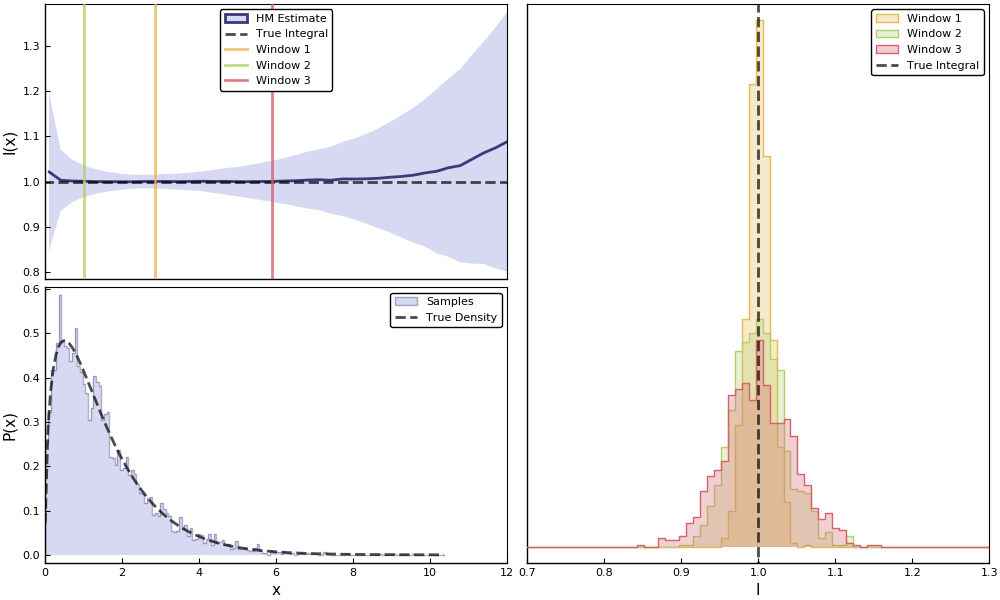

In [69]:
p1 = plot(hist, 
        seriestype = :steps, 
        linecolor=line_colors[1], 
        linealpha=0.4,
        fill=true, 
        fillcolor=line_colors[4],
        fillalpha=0.4, 
        label="Samples"
    )

p1 = plot!(bins, x->density_f(x), 
        linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, 
        label="True Density"
    )

p1 = plot!(grid=:false, 
        xlims=(0.0, x_range[end]), 
        frame=true, 
        xlabel="x", 
        ylabel="P(x)"
    )

p2 = plot(x_range, mean_int,
        lw=2, 
        linecolor=line_colors[1], 
        fillcolor=line_colors[4], 
        ribbon=std_int,  
        fillalpha=0.4,  
        label="HM Estimate"
    )

p2 = hline!([1], linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, label="True Integral"
    )

p2 = vline!([x_range[Ind_2]], 
        linecolor=lc2,
        lw=2, 
        linealpha=0.8,
        label="Window 1"
    )

p2 = vline!([x_range[Ind_1]], 
        linecolor=lc1,
        lw=2, 
        linealpha=0.8,
        label="Window 2"
    )


p2 = vline!([x_range[Ind_3]], 
        linecolor=lc3,
        lw=2, 
        linealpha=0.8,
        label="Window 3"
    )

p2 = plot!(legend=:top, 
        xlims=(0.0, x_range[end]),
        ylabel="I(x)",     
        grid=false, 
        frame=true, 
        xaxis=nothing,
    )

p3 = plot(histogram_2, 
        seriestype = :steps, 
        linecolor=lc2, 
        linealpha=1,
        lw=1,
        fill=true, 
        fillcolor=lc2,
        fillalpha=0.3, 
        label="Window 1",
        xlims=(0.9, 1.1)
    )

p3 = plot!(histogram_1, 
        seriestype = :steps, 
        linecolor=lc1, 
        linealpha=1,
        lw=1,
        fill=true, 
        fillcolor=lc1,
        fillalpha=0.3, 
        label="Window 2",
        xlims=(0.9, 1.1)
    )

p3 = plot!(histogram_3, 
        seriestype = :steps, 
        linecolor=lc3, 
        linealpha=1,
        lw=1,
        fill=true, 
        fillcolor=lc3,
        fillalpha=0.3, 
        label="Window 3",
        xlims=(0.7, 1.3)
    )

p3 = vline!([1], 
        linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, 
        label="True Integral",
        grid=false,
        frame=true, 
        yaxis=nothing, xlabel="I"
    )



p4 = plot(p2, p1, layout = (2,1))
p5 = plot(p4, p3, layout=(1,2), size=(1000,600))

# Normal Distribution Example: 

In [33]:
# Define target density function: 

density_f(x; μ=0.0, σ=1) = 2*pdf(Normal(μ, σ),x...) 

density_f (generic function with 1 method)

In [34]:
# Generate MCMC Samples using BAT

prior = NamedTupleDist(x =[0.0 .. 10.0] )

Norm_prior = 10

log_likelihood = let f = density_f
    params ->  LogDVal(log(f(params.x)))
end

posterior = PosteriorDensity(log_likelihood, prior)

nsamples = 10^3
nchains = 6

samples = bat_sample(posterior, (nsamples, nchains), MetropolisHastings()).result;

┌ Info: Trying to generate 6 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 6 chains, 0 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 6 chains, 6 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 6 chains successful after 2 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:109


In [35]:
# Create histogram

samples_vector = flatview(unshaped.(samples.v))[1,:]
samples_likelihoods = exp.(samples.logd) * Norm_prior
samples_weights = samples.weight

bins = range(minimum(samples_vector), stop = maximum(samples_vector), length = 100)
hist = fit(Histogram, samples_vector, weights(samples_weights), bins);
hist = normalize(hist, mode=:pdf);

In [36]:
x_range =  range(0.05, stop=4.5, length=40)

# Generate Experiments: 

hm_estimates, r_estimates, cuba_integrals = generate_hm_data(posterior, x_range, Norm_prior, density_f, n_trials=1000);

int_tmp = hm_estimates.*r_estimates

mean_hm = mean(hm_estimates, dims=2)[:,1]
std_hm = std(hm_estimates, dims=2)[:,1]

mean_r = mean(r_estimates, dims=2)[:,1]
std_r = std(r_estimates, dims=2)[:,1]

mean_int = mean(int_tmp, dims=2)[:,1]
std_int = std(int_tmp, dims=2)[:,1];

┌ Info: Trying to generate 3 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 3 chains, 0 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 3 chains, 3 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 3 chains successful after 2 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:109
┌ Info: Trying to generate 3 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/git

In [37]:
# Cutt-off positions: 

Ind_1 = 4
Ind_2 = 10 
Ind_3 = 30

lc1 = line_colors[7]
lc2 = line_colors[11]
lc3 = line_colors[15]

bins_integrals = range(minimum(int_tmp), stop = maximum(int_tmp), length = 120)

histogram_1 = fit(Histogram, int_tmp[Ind_1,:], bins_integrals);
histogram_1 = normalize(histogram_1, mode=:pdf);

histogram_2 = fit(Histogram, int_tmp[Ind_2,:], bins_integrals);
histogram_2 = normalize(histogram_2, mode=:pdf);

histogram_3 = fit(Histogram, int_tmp[Ind_3,:], bins_integrals);
histogram_3 = normalize(histogram_3, mode=:pdf);

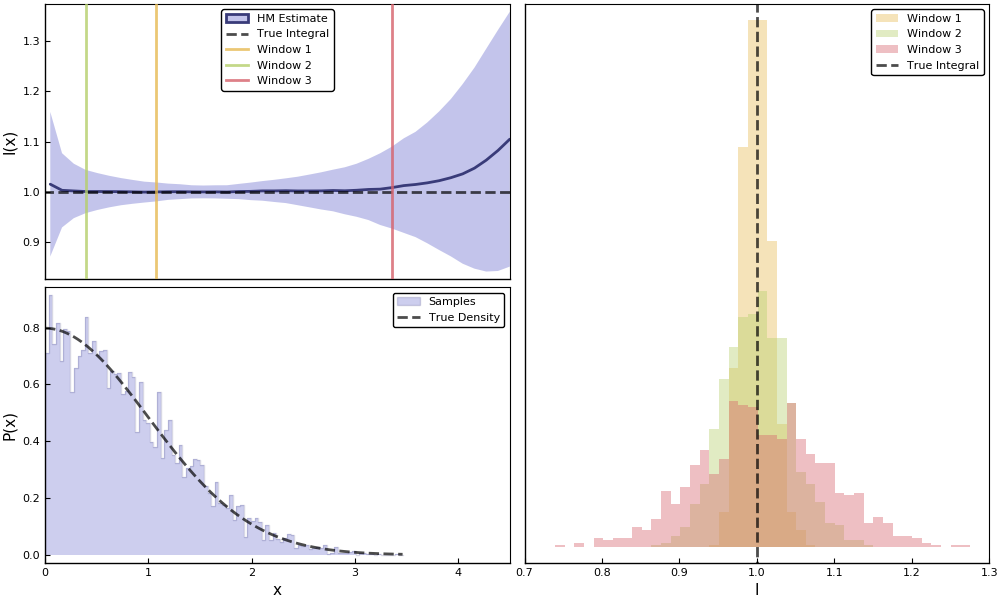

In [38]:
p1 = plot(hist, 
        seriestype = :steps, 
        linecolor=line_colors[1], 
        linealpha=0.2,
        fill=true, 
        fillcolor=line_colors[4],
        fillalpha=0.5, 
        label="Samples"
    )

p1 = plot!(bins, x->density_f(x), 
        linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, 
        label="True Density"
    )

p1 = plot!(grid=:false, 
        xlims=(0.0, x_range[end]), 
        frame=true, 
        xlabel="x", 
        ylabel="P(x)"
    )

p2 = plot(x_range, mean_int,
        lw=2, 
        linecolor=line_colors[1], 
        fillcolor=line_colors[4], 
        ribbon=std_int,  
        fillalpha=0.6,  
        label="HM Estimate"
    )

p2 = hline!([1], linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, label="True Integral"
    )

p2 = vline!([x_range[Ind_2]], 
        linecolor=lc2,
        lw=2, 
        linealpha=0.8,
        label="Window 1"
    )

p2 = vline!([x_range[Ind_1]], 
        linecolor=lc1,
        lw=2, 
        linealpha=0.8,
        label="Window 2"
    )


p2 = vline!([x_range[Ind_3]], 
        linecolor=lc3,
        lw=2, 
        linealpha=0.8,
        label="Window 3"
    )

p2 = plot!(legend=:top, 
        xlims=(0.0, x_range[end]),
        ylabel="I(x)",     
        grid=false, 
        frame=true, 
        xaxis=nothing,
    )

p3 = plot(histogram_2, 
        seriestype = :steps, 
        linecolor=lc2, 
        linealpha=1,
        lw=1,
        fill=true, 
        fillcolor=lc2,
        fillalpha=0.3, 
        label="Window 1",
        xlims=(0.9, 1.1)
    )

p3 = plot!(histogram_1, 
        seriestype = :steps, 
        linecolor=lc1, 
        linealpha=1,
        lw=1,
        fill=true, 
        fillcolor=lc1,
        fillalpha=0.3, 
        label="Window 2",
        xlims=(0.9, 1.1)
    )

p3 = plot!(histogram_3, 
        seriestype = :steps, 
        linecolor=lc3, 
        linealpha=1,
        lw=1,
        fill=true, 
        fillcolor=lc3,
        fillalpha=0.3, 
        label="Window 3",
        xlims=(0.7, 1.3)
    )

p3 = vline!([1], 
        linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, 
        label="True Integral",
        grid=false,
        frame=true, 
        yaxis=nothing, xlabel="I"
    )

p4 = plot(p2, p1, layout = (2,1))
p5 = plot(p4, p3, layout=(1,2), size=(1000,600))

# Normal Distribution Example: 

In [39]:
# Define target density function: 

# density_f(x; μ1=-1.5, μ2=1.5, σ=0.5) = (1/2)*(pdf(Normal(μ1, σ),x) + pdf(Normal(μ2, σ),x))

density_f(x; μ=0.0, σ=0.4) = pdf(Normal(μ, σ),x...) 

density_f (generic function with 1 method)

In [40]:
# Generate MCMC Samples using BAT

prior = NamedTupleDist(x =[-10.0 .. 10.0] )

Norm_prior = 20

log_likelihood = let f = density_f
    params ->  LogDVal(log(f(params.x)))
end

posterior = PosteriorDensity(log_likelihood, prior)

nsamples = 10^3
nchains = 6

samples = bat_sample(posterior, (nsamples, nchains), MetropolisHastings()).result;

┌ Info: Trying to generate 6 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 6 chains, 0 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 6 chains, 2 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 6 chains, 6 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 6 chains successful after 3 cycle(s).
└ @ BAT /home/iwsatlas1/vhaf

In [41]:
# Create histogram

samples_vector = flatview(unshaped.(samples.v))[1,:]
samples_likelihoods = exp.(samples.logd) * Norm_prior
samples_weights = samples.weight

bins = range(minimum(samples_vector), stop = maximum(samples_vector), length = 100)
hist = fit(Histogram, samples_vector, weights(samples_weights), bins);
hist = normalize(hist, mode=:pdf);

In [42]:
x_range = range(0.02, stop=1.7, length=40)

# Generate Experiments: 

hm_estimates, r_estimates, cuba_integrals = generate_hm_data(posterior, x_range, Norm_prior, density_f, symmetric=true, n_trials=1000);

int_tmp = hm_estimates.*r_estimates

mean_hm = mean(hm_estimates, dims=2)[:,1]
std_hm = std(hm_estimates, dims=2)[:,1]

mean_r = mean(r_estimates, dims=2)[:,1]
std_r = std(r_estimates, dims=2)[:,1]

mean_int = mean(int_tmp, dims=2)[:,1]
std_int = std(int_tmp, dims=2)[:,1];

┌ Info: Trying to generate 3 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 3 chains, 0 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 3 chains, 3 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 3 chains successful after 2 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:109
┌ Info: Trying to generate 3 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/git

In [60]:
# Cutt-off positions: 

Ind_1 = 4
Ind_2 = 10 
Ind_3 = 30

lc1 = line_colors[6]
lc2 = line_colors[14]
lc3 = line_colors[10]

bins_integrals = range(minimum(int_tmp), stop = maximum(int_tmp), length = 120)

histogram_1 = fit(Histogram, int_tmp[Ind_1,:], bins_integrals);
histogram_1 = normalize(histogram_1, mode=:pdf);

histogram_2 = fit(Histogram, int_tmp[Ind_2,:], bins_integrals);
histogram_2 = normalize(histogram_2, mode=:pdf);

histogram_3 = fit(Histogram, int_tmp[Ind_3,:], bins_integrals);
histogram_3 = normalize(histogram_3, mode=:pdf);

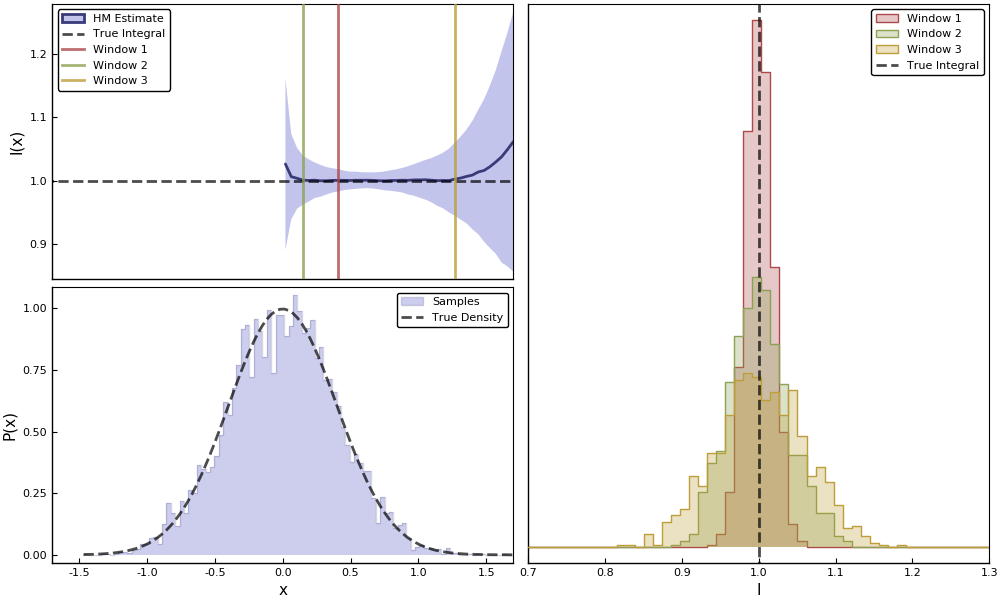

In [61]:
p1 = plot(hist, 
        seriestype = :steps, 
        linecolor=line_colors[1], 
        linealpha=0.2,
        fill=true, 
        fillcolor=line_colors[4],
        fillalpha=0.5, 
        label="Samples"
    )

p1 = plot!(bins, x->density_f(x), 
        linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, 
        label="True Density"
    )

p1 = plot!(grid=:false, 
        xlims=(-x_range[end], x_range[end]), 
        frame=true, 
        xlabel="x", 
        ylabel="P(x)"
    )

p2 = plot(x_range, mean_int,
        lw=2, 
        linecolor=line_colors[1], 
        fillcolor=line_colors[4], 
        ribbon=std_int,  
        fillalpha=0.6,  
        label="HM Estimate"
    )

p2 = hline!([1], linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, label="True Integral"
    )

p2 = vline!([x_range[Ind_2]], 
        linecolor=lc2,
        lw=2, 
        linealpha=0.8,
        label="Window 1"
    )

p2 = vline!([x_range[Ind_1]], 
        linecolor=lc1,
        lw=2, 
        linealpha=0.8,
        label="Window 2"
    )


p2 = vline!([x_range[Ind_3]], 
        linecolor=lc3,
        lw=2, 
        linealpha=0.8,
        label="Window 3"
    )

p2 = plot!(legend=:topleft, 
        xlims=(-x_range[end], x_range[end]),
        ylabel="I(x)",     
        grid=false, 
        frame=true, 
        xaxis=nothing,
    )

p3 = plot(histogram_2, 
        seriestype = :steps, 
        linecolor=lc2, 
        linealpha=1,
        lw=1,
        fill=true, 
        fillcolor=lc2,
        fillalpha=0.3, 
        label="Window 1",
        xlims=(0.9, 1.1)
    )

p3 = plot!(histogram_1, 
        seriestype = :steps, 
        linecolor=lc1, 
        linealpha=1,
        lw=1,
        fill=true, 
        fillcolor=lc1,
        fillalpha=0.3, 
        label="Window 2",
        xlims=(0.9, 1.1)
    )

p3 = plot!(histogram_3, 
        seriestype = :steps, 
        linecolor=lc3, 
        linealpha=1,
        lw=1,
        fill=true, 
        fillcolor=lc3,
        fillalpha=0.3, 
        label="Window 3",
        xlims=(0.7, 1.3)
    )

p3 = vline!([1], 
        linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, 
        label="True Integral",
        grid=false,
        frame=true, 
        yaxis=nothing, xlabel="I"
    )

p4 = plot(p2, p1, layout = (2,1))
p5 = plot(p4, p3, layout=(1,2), size=(1000,600))

## Exact Calculation: 

In [ ]:
# CUBA integral: 

# cuba_integral = hcubature(density_f, [0.0], [10]) 

In [ ]:
# ahmi_integral = bat_integrate(samples).result .* Norm_prior

In [ ]:
# likelihood_val = exp.(samples.logd) * Norm_prior

# V = 1 #maximum(samples_flat) - minimum(samples_flat)

# @show I_hm = (sum(samples.weight * V)) /(sum(samples.weight ./ likelihood_val)) 
# @show I_hm = (sum(samples.weight * Norm_prior)) /(sum(samples.weight ./ likelihood_val)) 

# Plot Cubes: 

In [ ]:
# x1_min = -2
# x1_max = -1
# x2_min = 1
# x2_max = 2

# p = vspan([x1_min, x1_max, x2_min, x2_max], 
#         linecolor=:black, 
#         fillcolor=:gray, 
#         label="", 
#         linealpha=0.0, 
#         fillalpha=0.2
#     )

# p = plot!(hist, 
#         seriestype = :steps, 
#         linecolor=line_colors[13], 
#         linealpha=0.0,
#         fill=true, 
#         fillcolor=line_colors[16],
#         fillalpha=0.8, 
#         label="",
#     )

# p = plot!(grid=:false, frame=true, xlabel="x", ylabel="P(x)")